## Genome Computing
### Genomic Structures & Heatmaps

Please load the following Python libraries before getting started:

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

This tutorial notebook will focus on how to generate a 2D heatmap. We will work with the following libraries and functions:
- pandas
- matplotlib.pyplot
   - pcolormesh
   - colorbar
- scipy.spatial.distance
   - pdist()
   - cdist()
   - squareform()
   

At any time during this tutorial you can search for the documentation of any of the libraries and functions through any search engine

A 2D heatmap can be thought of as a "psuedo 3D plot" in that you have an x-axis and a y-axis and each point on the graph is a color. These colors represent ranges of some particular set of data. For example, take a look at this heatmap found in a 23 Jun 2022 article from the Washington Post (https://www.washingtonpost.com/climate-environment/interactive/2022/maps-heat-wave-climate-change-us/):
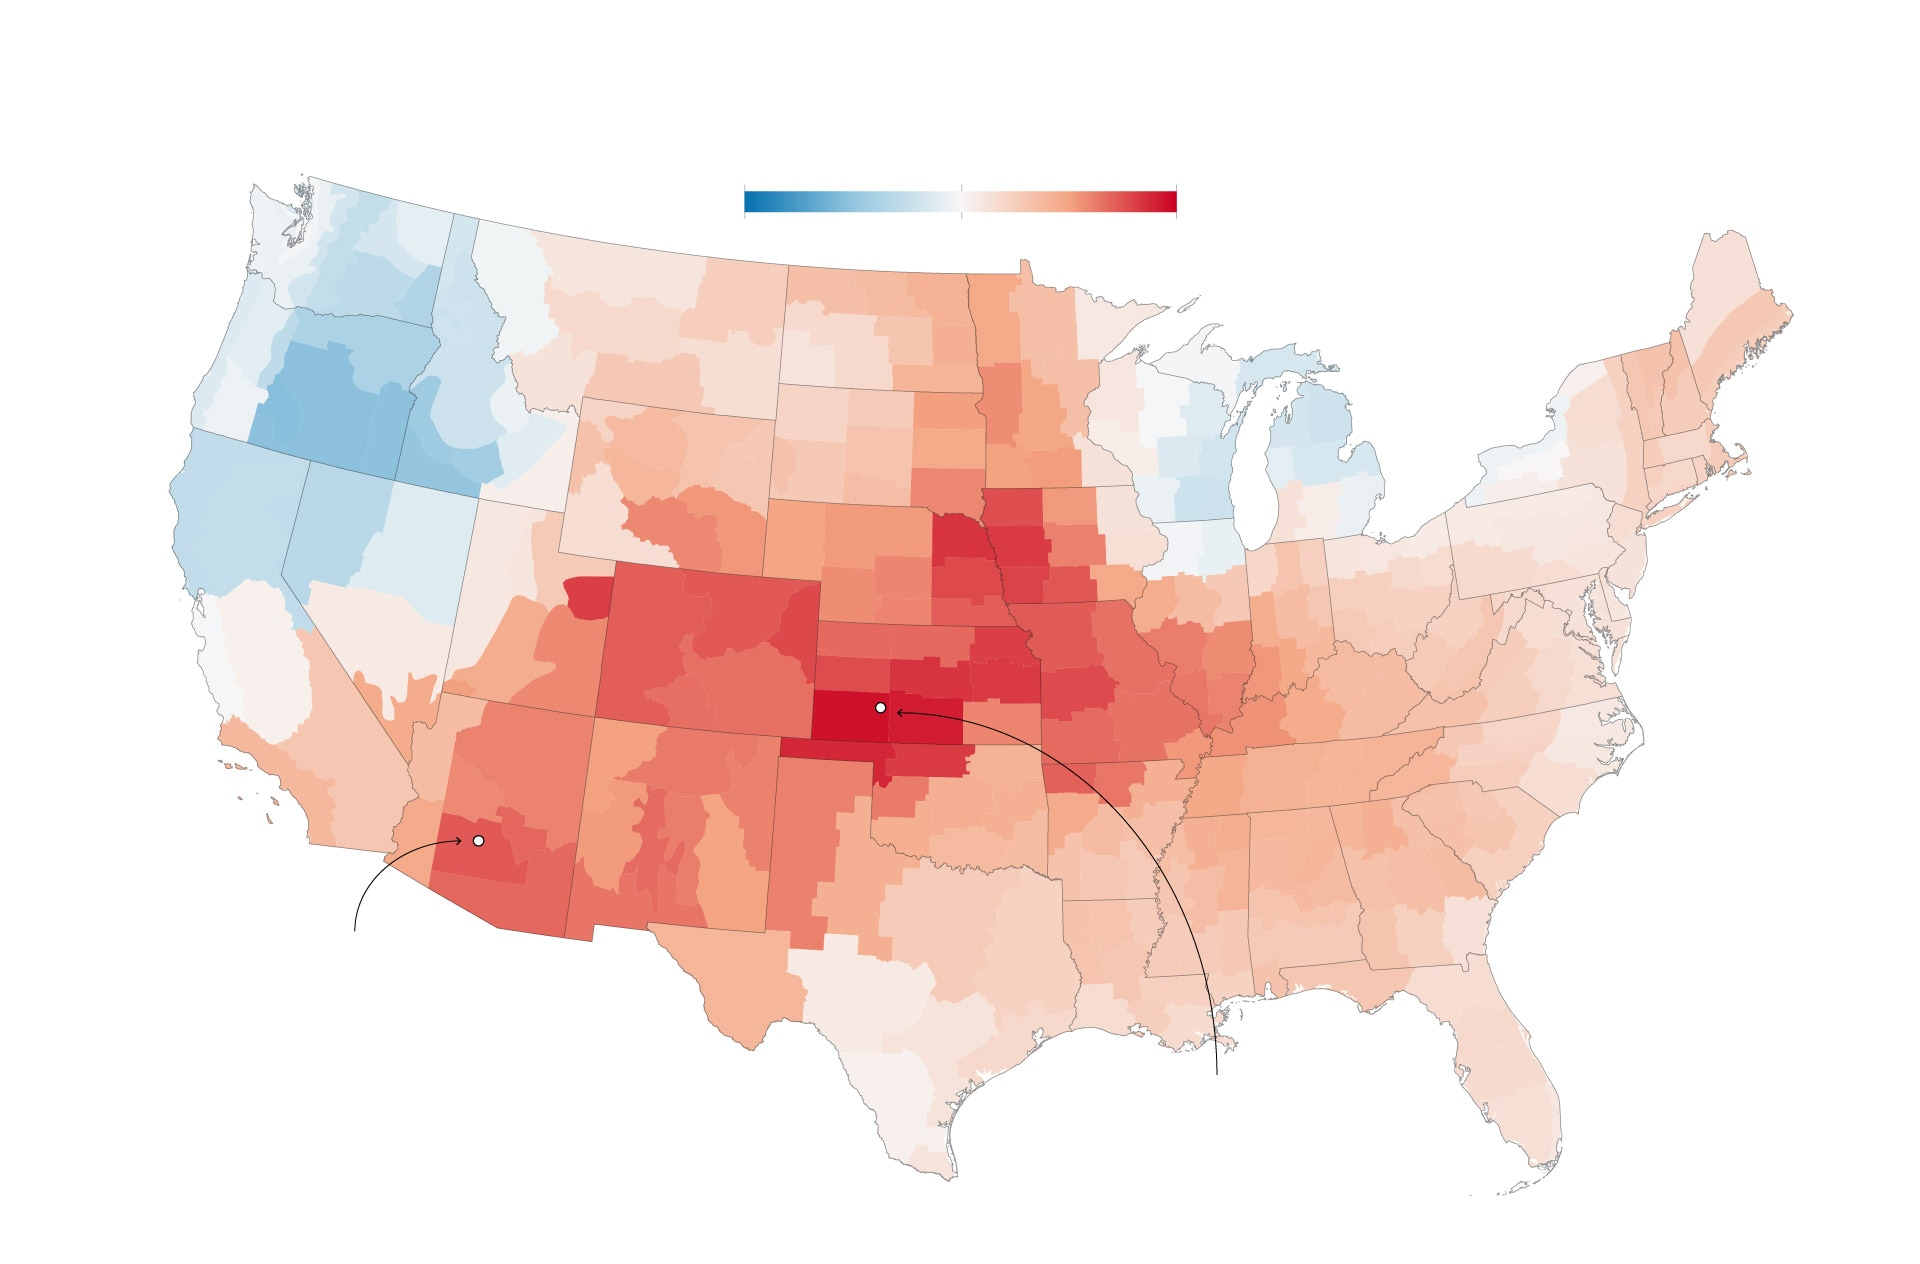
For this, the x-axis and y-axis are the latitude and longitude coordinates of the continental US, respectively. The colors- our third dimension- represents temperature differences across a ~30 year span.

We can apply heatmaps to structures if we wanted a clearer way to explain distance relations. Follow the code below as we work with the nucloop.pdb structure.

In [ ]:
# Load the .pdb file
with open("datafiles/nucloop.pdb", "r") as infile:
    indata = infile.readlines()
    
    # Keep only atomic position data
    indata=[i for i in indata if i.startswith('ATOM')]
    
    # Generate 2 separate pandas DataFrames: 
    # ... chain A phosphorous positions
    pdata1=[i.split()[6:9]for i in indata if i.split()[2]=='P' and i.split()[4]=='A']
    df_A = pd.DataFrame(pdata1, columns=['x','y','z']).astype(float)
    del pdata1
    
    # ... and chain B phosphorous positions
    pdata2=[i.split()[6:9]for i in indata if i.split()[2]=='P' and i.split()[4]=='B']
    df_B = pd.DataFrame(pdata2, columns=['x','y','z']).astype(float)
    del pdata2
    
    del indata
    infile.close()


In [ ]:
df_A.head(5)

In [ ]:
df_B.head(5)

In [ ]:
# Make a 3D plot of the positions in space.
# This will just be 2 lines that trace the positions in both dataframes

fig = plt.figure(figsize=(5,5))

ax = plt.axes(projection='3d')

ax.plot(df_A.x, df_A.y, df_A.z, color='blue')
ax.plot(df_B.x, df_B.y, df_B.z, color='red')

plt.tight_layout()
plt.show()
plt.clf()

# The figure below should look like the coiling of blue and red chains similar to a DNA helix

This is a nice figure but it really doesn't tell us anything that we cannot make better in a molecular visualization program like PyMOL.

We can get a sense of how far all of the positions are relative to each other. We know the distance formula from previous work:

$\sqrt{(x_2-x_1)^2+(y_2-y_1)^2+(z_2-z_1)^2}$

In mathematical terms this is called the Euclidean distance formula. This will come in handy when working with SciPy.

### SciPy and .pdist()

One can use the SciPy library for various calculations. One example are all of the spatial distance calculations one can make: https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

In [ ]:

import scipy.spatial.distance as spdist

# -!- You can choose to use scipy.spatial.distance in your code. This just simplifies our coding

One method we can use is `.pdist()`: pdist(X[, metric, out]) | Pairwise distances between observations in n-dimensional space.

In the documentation, 'X' refers to the array of data for the calculation and 'metric' is an optional keyword for the kind of distance calculation to use. Additional keywords can be use to use statistical weights or the variance vector to standardize the data.

Let's calculate the distances of all the chain A phosphorous atoms:

In [ ]:
dist = spdist.pdist(df_A, "euclidean")

dist


This is a 1D array. We want to make a 2D plot.

This is where `.squareform()` comes in handy. Use this function to generate a square, symmetric matrix made from the 1D vector. (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html#scipy.spatial.distance.squareform)


In [ ]:
distances = spdist.squareform( dist )

distances


With our matrix, let's make our heatmap.

We will use the `matplotlib.pyplot.pcolormesh()` function (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html).

`pcolormesh([X, Y,] C, **kwargs)` will create a color plot where:
- C: the mesh, or array-like, data. This is our matrix
- [X, Y]: optional array-line values that can be used to specify the corners of the plot
- **kwargs: this is "keyword arguments", which are used to customize any figure



In [ ]:
# Make that heatmap!

fig = plt.figure()

plt.pcolormesh(distances)

plt.tight_layout()
plt.show()
plt.clf()

# We have our plot! Now...
# ... what does it MEAN?

In [ ]:
fig = plt.figure( figsize=(5,5) )

plt.pcolormesh(distances)

# We need to add a colorbar() to give us some sense of what we plotted
plt.colorbar()

plt.tight_layout()
plt.show()
plt.clf()

# The colors appear to show a lighter color based on a larger value. 
# This would mean that the lighter the color the futher the (x,y) point are.

In [ ]:
# Now to customize

fig = plt.figure( figsize=(6,5) )

# We can change the colors using the "cmap" keyword.
# BOOKMARK THIS LINK: https://matplotlib.org/stable/tutorials/colors/colormaps.html

plt.pcolormesh(distances, 
              cmap="coolwarm")

plt.colorbar(label="Distance (units: Angstroms)")

# Set the x- and y-axis labels so we know what's going on:
plt.xlabel("Phosphate Position Along Chain 'A'")
plt.ylabel("Phosphate Position Along Chain 'A'")


plt.tight_layout()
plt.show()
plt.clf()

Now the question: does this make sense?
We should see a diagonal of zeroes because at positions where x and y are the same, the distance should be 0: it's the same point in space.
The four pockets of red show these are four regions that are the futherest away. Use this image to help better visualize why:
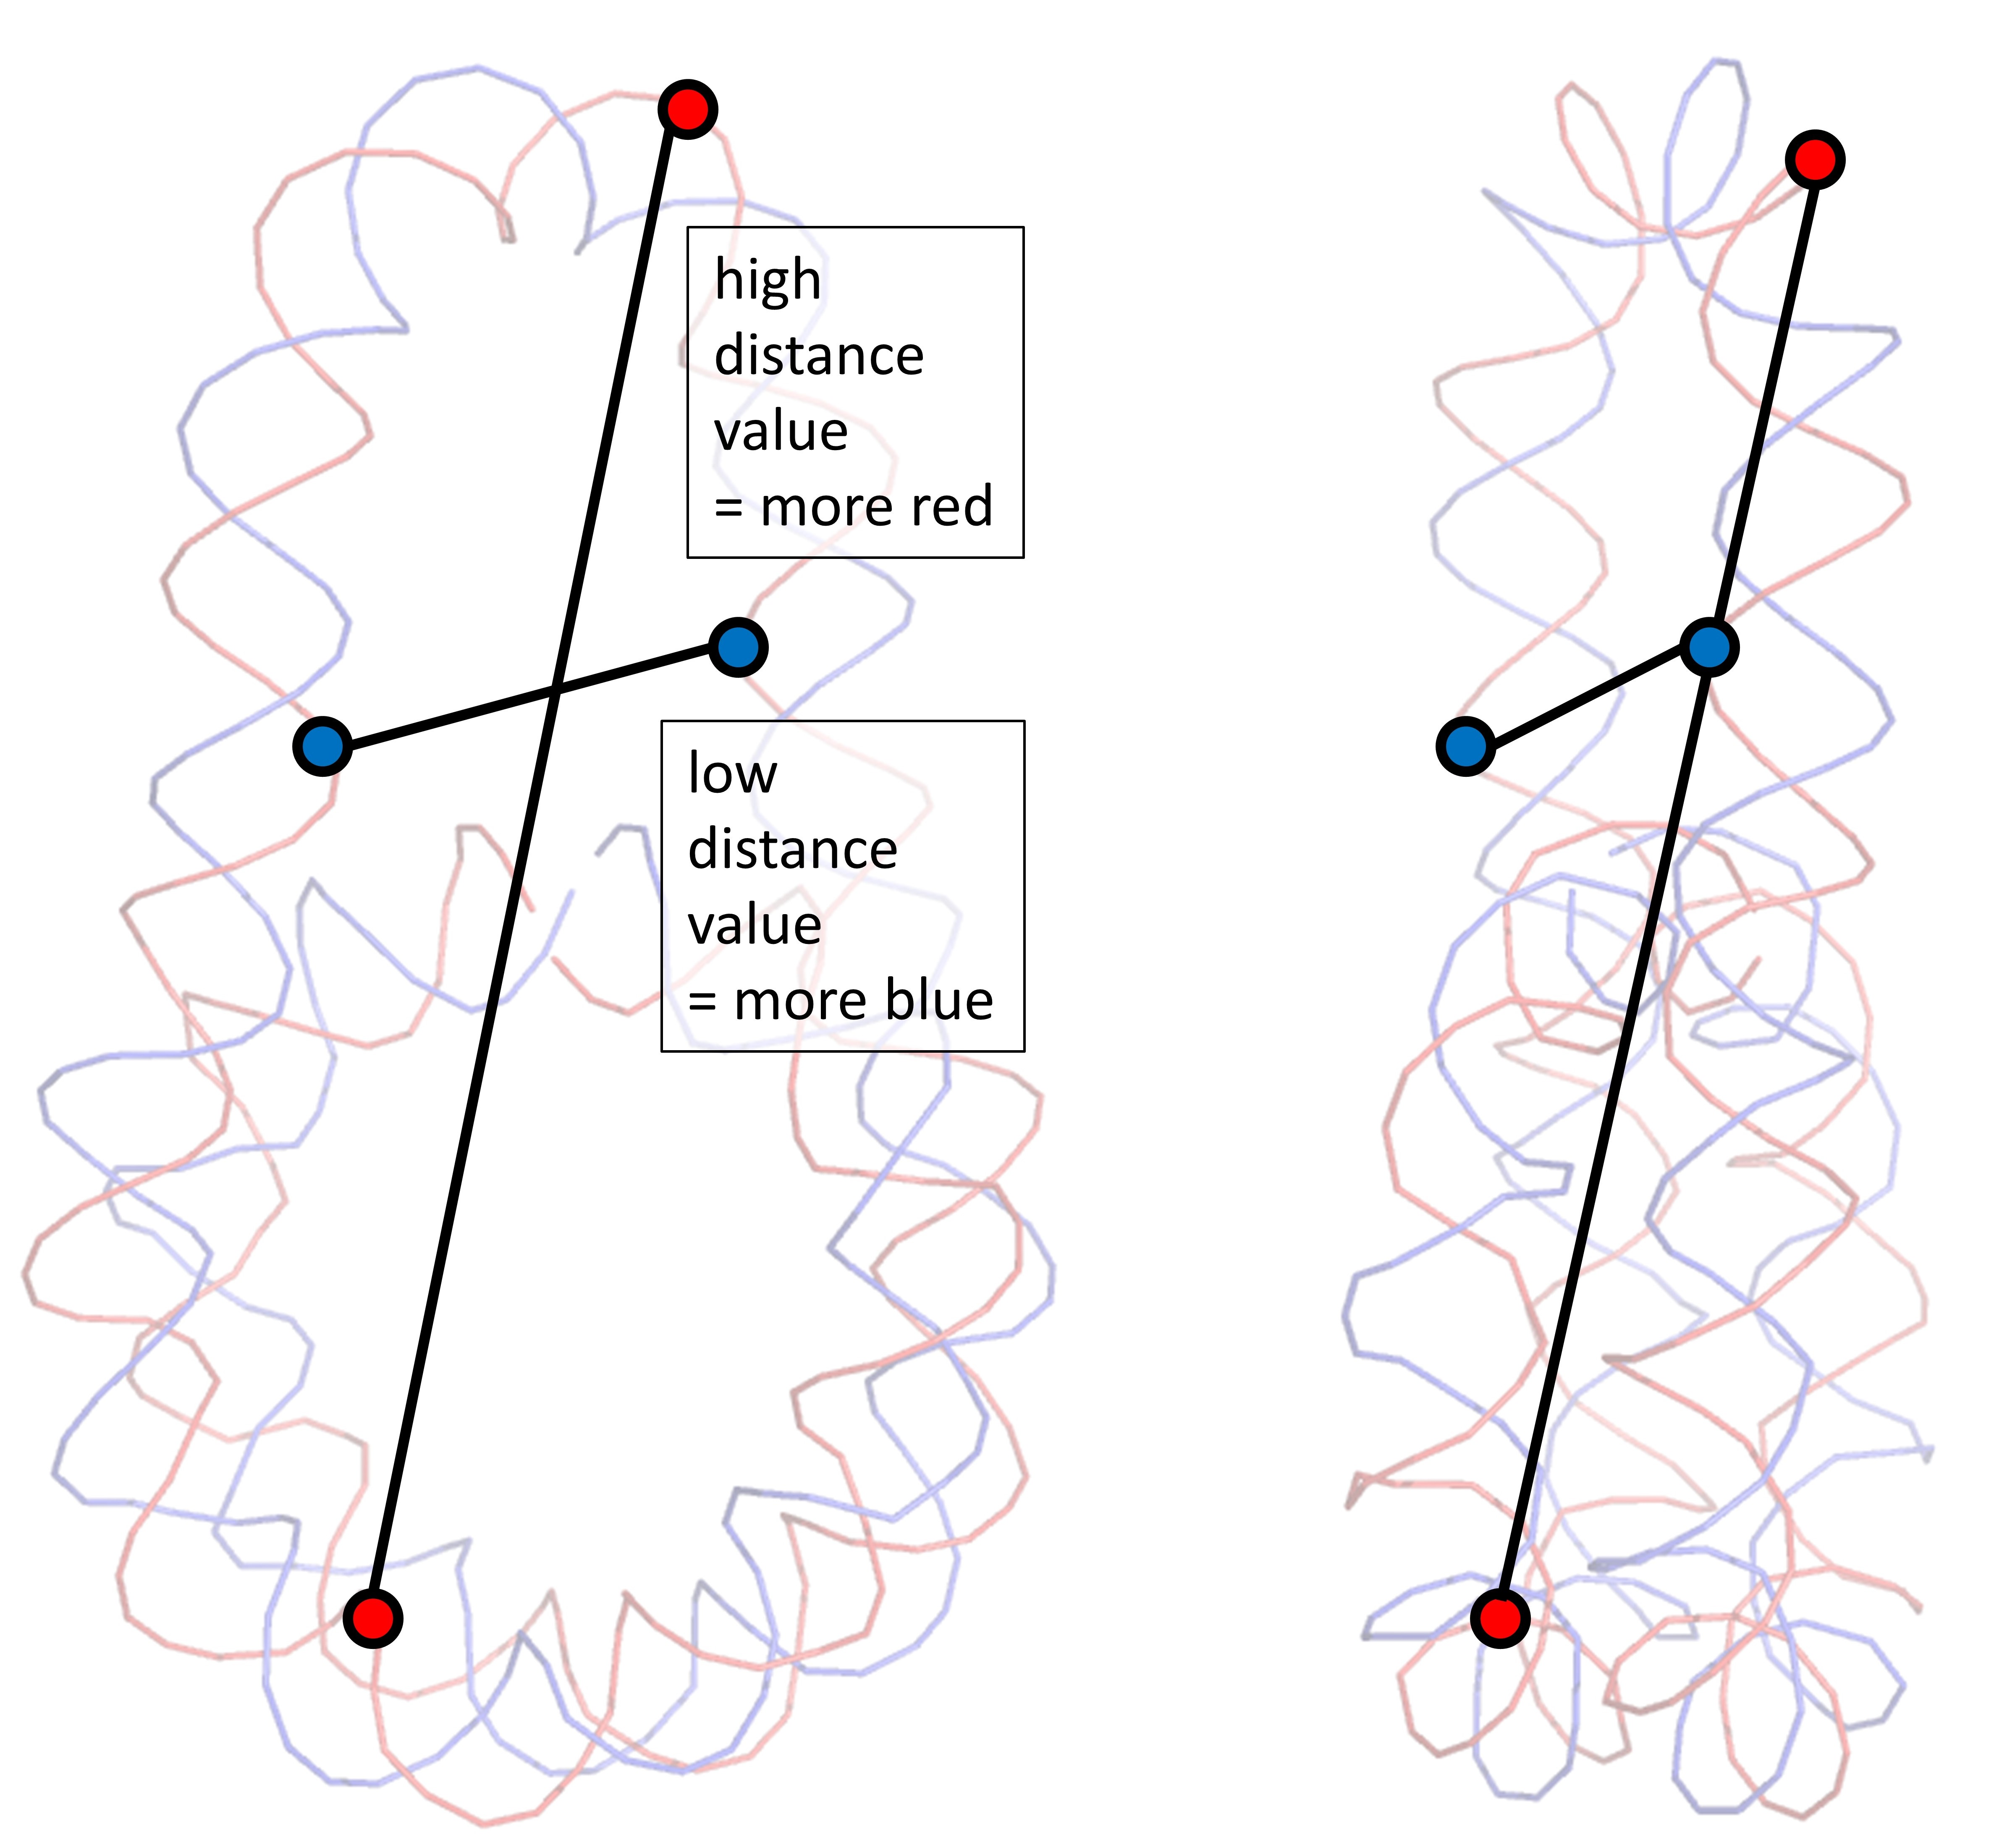


------------

### SciPy and .cdist()

We've seen how well `.pdist()` works, but note that it only works for 1 set of data. `.pdist()` works well for RNA and protein structures as this is just 1 set of position data.

What if we have two sets of data, such as a DNA chain and an RNA chain, or two different protein subunits? This is where `.cdist()` works: cdist(XA, XB[, metric, out]) | Compute distnace between each pair of the two collections of inputs.

Let's compare the two chains of phosphorous atoms from the two dataframes.

In [ ]:
dists = spdist.cdist(df_A,
                     df_B,
                     metric="euclidean")

dists

# A benefit to this is that this is already in a 2D form, so .squareform() won't be needed


In [ ]:
fig = plt.figure( figsize=(6,5) )

plt.pcolormesh(dists)
plt.colorbar()

plt.xlabel("Phosphate Position Along Chain 'A'")
plt.ylabel("Phosphate Position Along Chain 'B'")

plt.tight_layout()
plt.show()
plt.clf()

This looks a bit different than expected. Our diagonal is not in the same place as our .pdist().

Why is that? Remember how the DNA atoms are numbered along a chain.

Chain A = residue number   1 - 200

Chain B = residue number 201 - 400

And base <i>pairs</i> are not numbered in the same direction:
- The first base pair is resi 1 in chain A and resi 400 in chain B
- The last base pair is resi 200 in chain A and resi 201 in chain B
    
Knowing the numbering matters here. We need to invert our y-axis to get the numbering to match.

In [ ]:
fig = plt.figure( figsize=(6,5) )

plt.pcolormesh(dists,
              cmap="coolwarm")
plt.colorbar(label="Distance (units: Angstroms)")

# We will make an 'ax' object of our pyplot canvas, 
# ... use .gca() to get the current canvas being made, 
# ... and invert the direction of the y-axis
ax = plt.gca().invert_yaxis()

plt.xlabel("Phosphate Position Along Chain 'A'")
plt.ylabel("Phosphate Position Along Chain 'B'")

plt.tight_layout()
plt.show()
plt.clf()


In [ ]:

del df_A, df_B, dist, distances, dists


---------------------------------

### Bonus Content: Make your own heatmap

1. Go to the PDB and download the "1EHZ" transfer RNA model
2. Load this file and collect all the atomic positions
3. Generate a 2D heatmap using .pdist using the 'Spectral' colormap


In [ ]:
# Part 1: load structural file and make 1 dataframe of positions




In [ ]:
# Part 2: use .pdist() & .squareform()





In [ ]:
# Part 3: make your heatmap





Here is what you should shoot for:

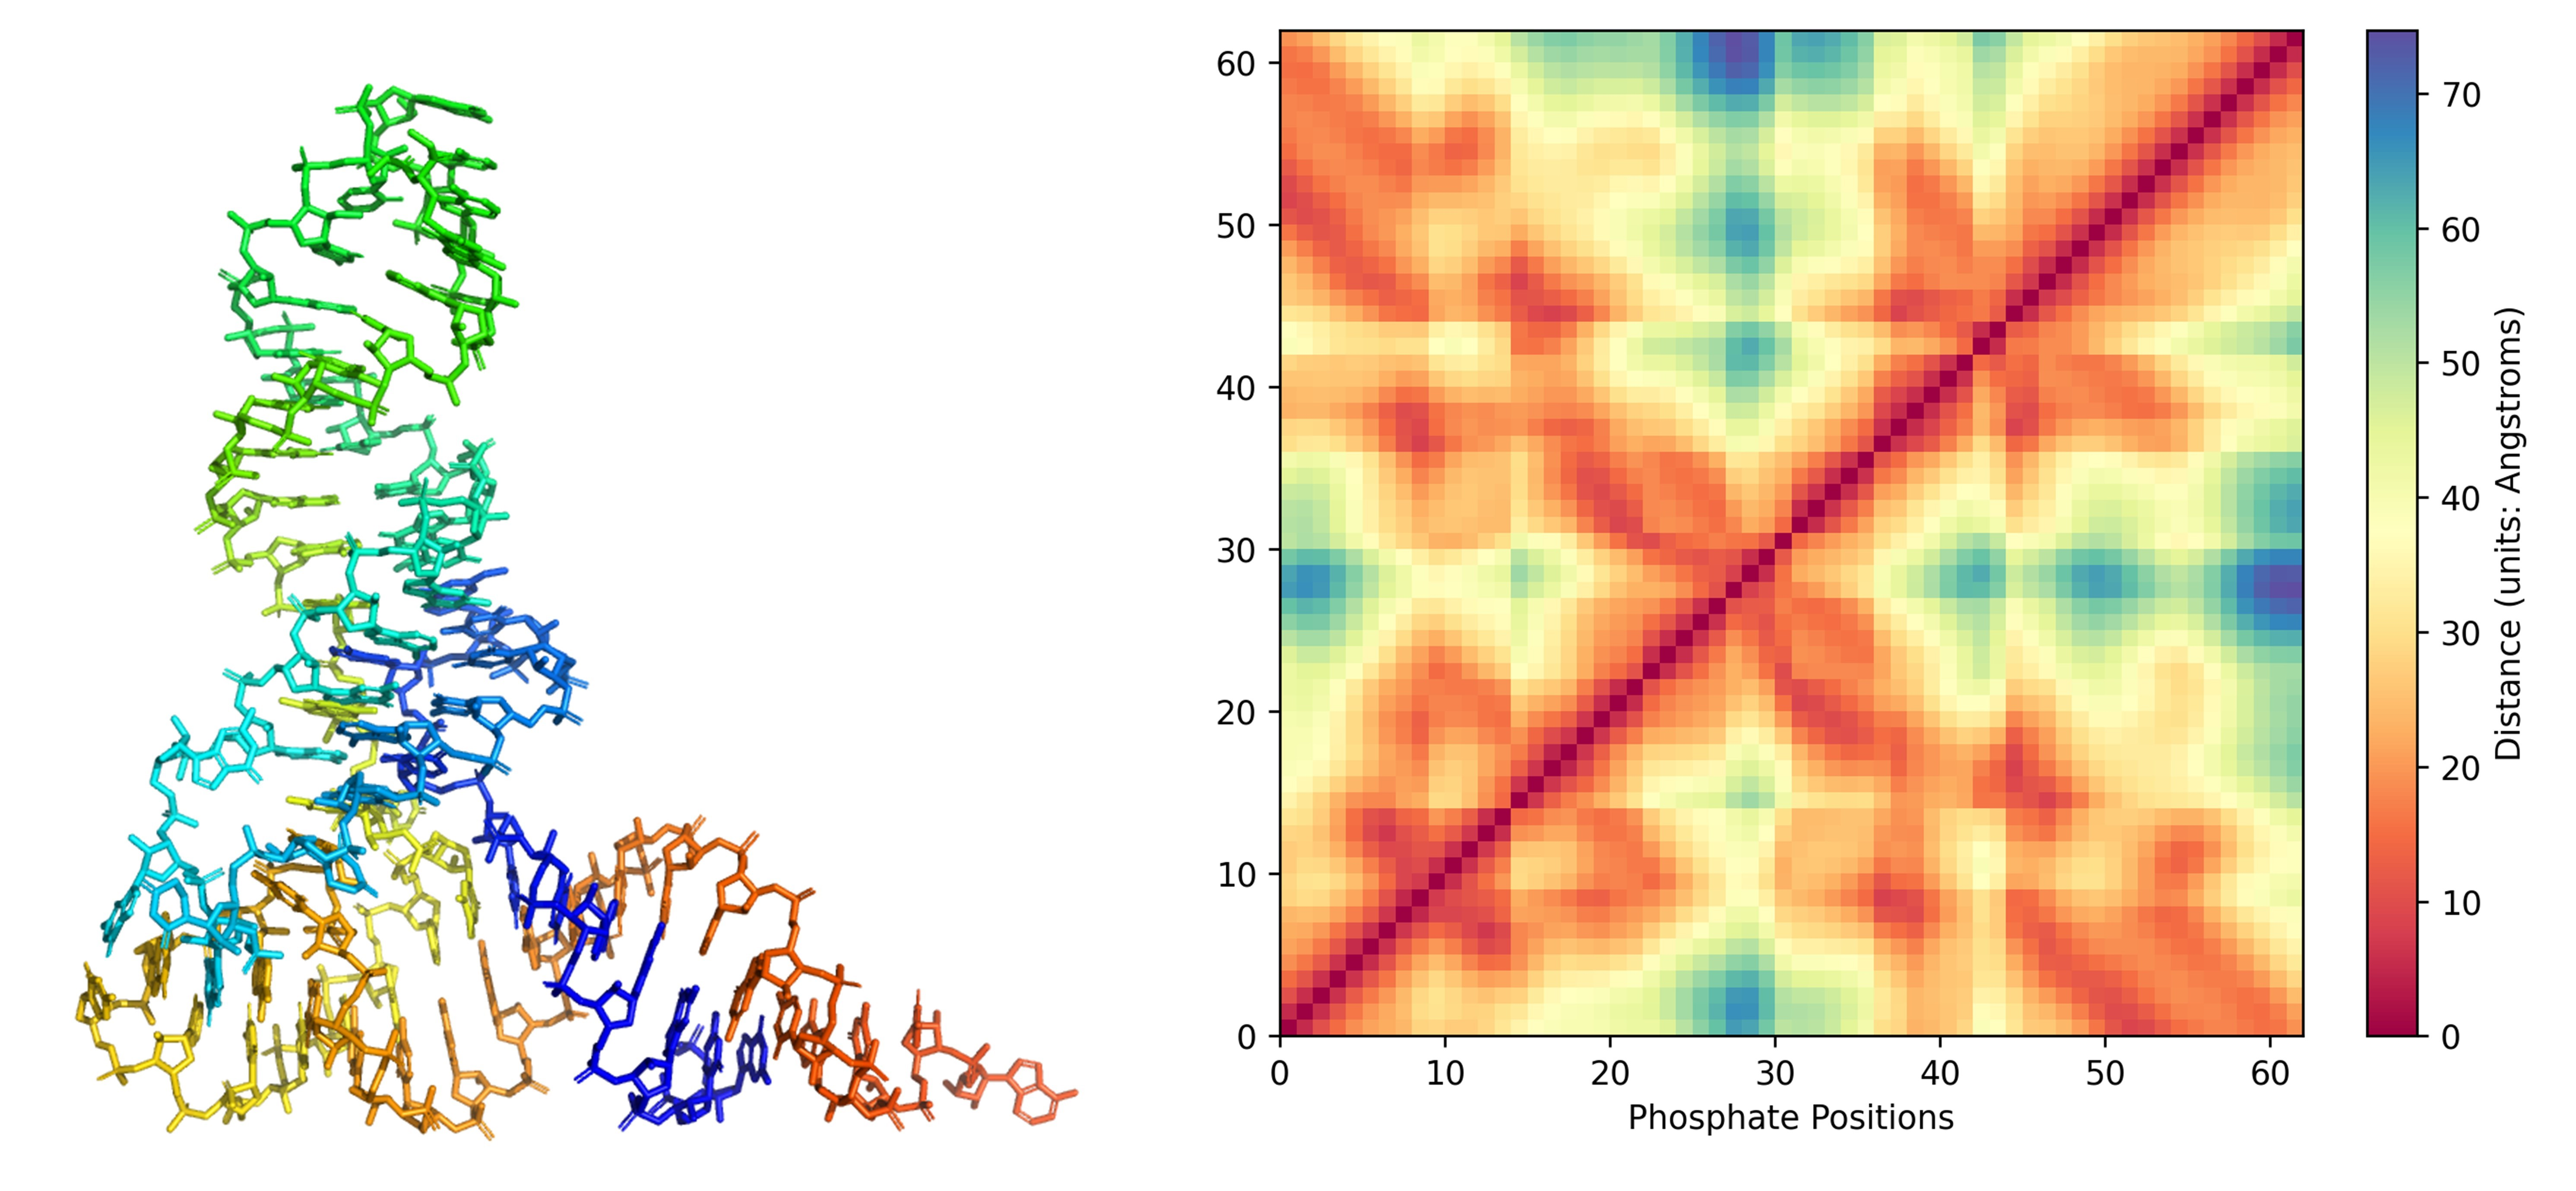

In [ ]:
# Dr. Robert Young, University of Maryland
# UMD FIRE Genome Computing